### Librerías

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from keras import backend as K

In [2]:
tf.config.set_visible_devices([], 'GPU')

# if tf.test.gpu_device_name(): # this lies and tells you about all devices
if tf.config.experimental.list_logical_devices('GPU'):
    print('GPU found')
else:
    print("No GPU found")

No GPU found


## Constantes

In [3]:
PATH = "../../"

In [4]:
MODEL_NAME = "MobileNetV2"

In [5]:
TARGET_IMG_WIDTH = 224
TARGET_IMG_HEIGHT = 224
TARGET_IMG_CHANNELS = 3
TARGET_SIZE = (TARGET_IMG_WIDTH, TARGET_IMG_HEIGHT)
TARGET_SHAPE = (TARGET_IMG_WIDTH, TARGET_IMG_HEIGHT, TARGET_IMG_CHANNELS)

OPTIMIZER = Adam()
LOSS = tf.keras.losses.SparseCategoricalCrossentropy()

# METRICS = [tf.keras.metrics.Accuracy, tf.keras.metrics.Precision, tf.keras.metrics.Recall]
METRICS = ['accuracy']
# METRICS = ['accuracy', 'loss', 'precision', 'recall', 'f1_score', 'auc_roc', 'sensitivity', 'specificity', 'top_k_accuracy']

In [6]:
CLASSES = ["caballo", "ciervo", "gamo", "humano", "jabali", "vaca", "vacia", "zorro"]
label = "vacia"

### Modelo

In [7]:
# Cargar el modelo entrenado
best_model_path = PATH + "Models/" + MODEL_NAME + "/best_model_20230704_1634_val_acc_0.5763.h5"
best_model = load_model(best_model_path)

In [8]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [9]:
capa_convolutiva = "out_relu"
# conv_1
# block_16_project
capa_clasificacion = "dense_5" # ultima capa

### Funciones

In [10]:
# Función para preprocesar la imagen
def preprocess_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, TARGET_SIZE)
    image = image.astype("float32") / 255.0
    return image

def predict_image(imagen, model):

    # Preprocesar la imagen
    imagen_preprocesada = preprocess_image(imagen)

    # Realizar la predicción
    prediccion = model.predict(np.expand_dims(imagen_preprocesada, axis=0), verbose=0)
    clase_predicha = np.argmax(prediccion)
    accuracy_prediccion = prediccion[0, clase_predicha]

    return prediccion, clase_predicha, accuracy_prediccion

In [53]:
# Directorio de la imagen de entrada

# test
#directorio_imagen = PATH + "Dataset/rev20/10/10_20220702 (6358).JPG"
#label = "vacia"

#directorio_imagen = PATH + "Dataset/rev21/2/2_20220806 (6611).JPG"
#label = "caballo"

#directorio_imagen = PATH + "Dataset/rev20/17/17_20220604 (17836).JPG"
#label = "gamo"

#directorio_imagen = PATH + "Dataset/rev15/10/10_20211217 (181).JPG"
#label = "ciervo"

#directorio_imagen = PATH + "Dataset/rev16/21_16/21_20220125 (3946).JPG"
#label = "jabali"

directorio_imagen = PATH + "Dataset/rev21/2/2_20220806 (6611).JPG"
label = "caballo"

# val
#directorio_imagen = PATH + "Dataset/rev22/9/9_20221006 (1503).JPG"
#label = "gamo"
#directorio_imagen = PATH + "Dataset/rev20/60/60_20220722 (1642).JPG"
#label = "humano"

directorio_imagen = PATH + "Dataset/rev01/29/29_20201117 (1018).JPG"
label = "humano"

directorio_imagen =  PATH + "Dataset/rev13/16/16_20211116 (859).JPG"
label = "ciervo"


In [54]:
# Cargar la imagen
image = cv2.imread(directorio_imagen)

# Realizar la predicción
prediction, predicted_class, accuracy = predict_image(image, best_model)

In [55]:
# Mapa de calor
# Obtener las salidas de las capas de interés
conv_output = best_model.get_layer(capa_convolutiva).output
# conv_output = best_model.get_layer("block_16_project").output
predictions = best_model.output

# Crear el modelo del mapa de calor
heatmap_model = tf.keras.models.Model(best_model.inputs, [conv_output, predictions])

with tf.GradientTape(persistent=True) as tape:
    conv_outputs, predictions = heatmap_model(np.expand_dims(preprocess_image(image), axis=0))
    loss = predictions[:, predicted_class]

In [56]:
grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=1)
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
heatmap = np.maximum(heatmap, 0)

max_value = np.max(heatmap)
if max_value != 0.0 and not np.isnan(max_value):
    heatmap /= max_value
else:
    heatmap = np.zeros_like(heatmap)

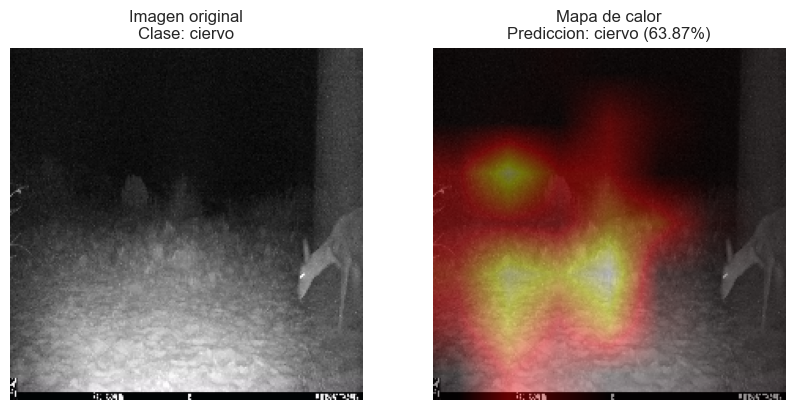

In [57]:
# Cargar y preprocesar la imagen original
imagen_original = cv2.imread(directorio_imagen)
imagen_preprocesada = preprocess_image(image)

# Generar la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Mostrar la imagen original en el primer subplot
ax1.imshow(imagen_preprocesada)
ax1.axis('off')

# Redimensionar el mapa de calor a (224, 224) con cv2.resize()
heatmap_resized = cv2.resize(heatmap[0], (224, 224), interpolation=cv2.INTER_LINEAR)

# Mostrar el mapa de calor en el segundo subplot
ax2.imshow(imagen_preprocesada)
ax2.imshow(heatmap_resized, alpha=0.4, cmap='hot') # jet
# plt.colorbar()
ax2.axis('off')

# Añadir títulos a los subplots
ax1.set_title('Imagen original\nClase: ' + label)
ax2.set_title('Mapa de calor\nPrediccion: ' + str(CLASSES[predicted_class]) + " (" + str(round(accuracy*100,2)) + "%)")

# Mostrar la figura
plt.show()